# Single and Bi-Tensor models

In [1]:
import os
import os.path
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

module_path = os.path.join(os.path.abspath(os.path.join('..')), 'pymods')
if module_path not in sys.path:
    sys.path.append(module_path)
from plotutils import plot_3d_z_indices

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import nibabel as nib


In [2]:
base_filename = "../data/output/S264294/S264294_DTI_gated_20150508093306_12"

In [3]:
#fdwi = base_filename + "_crop.nii.gz"
fdwi = base_filename + "_fw.nii.gz"
fbval = base_filename + ".bval"
fbvec = base_filename + ".bvec"

In [4]:
img = nib.load(fdwi)
data = img.get_data()

In [5]:
data.shape

(51, 43, 9, 65)

In [6]:
print(img.header.get_zooms()[:3])

(1.9827586, 1.9827586, 2.0)


In [7]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

In [8]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [9]:
gtab.info

B-values shape (65,)
         min 0.000000 
         max 1000.000000 
B-vectors shape (65, 3)
         min -0.964118 
         max 0.999988 


In [10]:
# b values for single shell
print(gtab.bvals)

[   0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000.]


In [11]:
# First few gradient directions
print(gtab.bvecs[:10, :])

[[ 0.          0.          0.        ]
 [ 0.999975   -0.00504502 -0.00503994]
 [ 0.          0.999988   -0.00497989]
 [-0.0249489   0.65464    -0.755529  ]
 [ 0.589353   -0.769866   -0.244886  ]
 [-0.235876   -0.529835   -0.81464   ]
 [-0.893575   -0.264756   -0.36253   ]
 [ 0.797989    0.133987   -0.58759   ]
 [ 0.232856    0.932211   -0.277056  ]
 [ 0.936737    0.145261   -0.31847   ]]


In [12]:
S0s = data[:, :, :, gtab.b0s_mask]
S0s.shape

(51, 43, 9, 1)

In [13]:
data.dtype

dtype('<i2')

In [14]:
S0s[:,:,6, 0].max()

1466

In [15]:
S0s[:,:,:, 0].min()

0

# Single Compartment model

In [16]:
import dipy.reconst.dti as dti
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data)

## Fractional Anisotropy

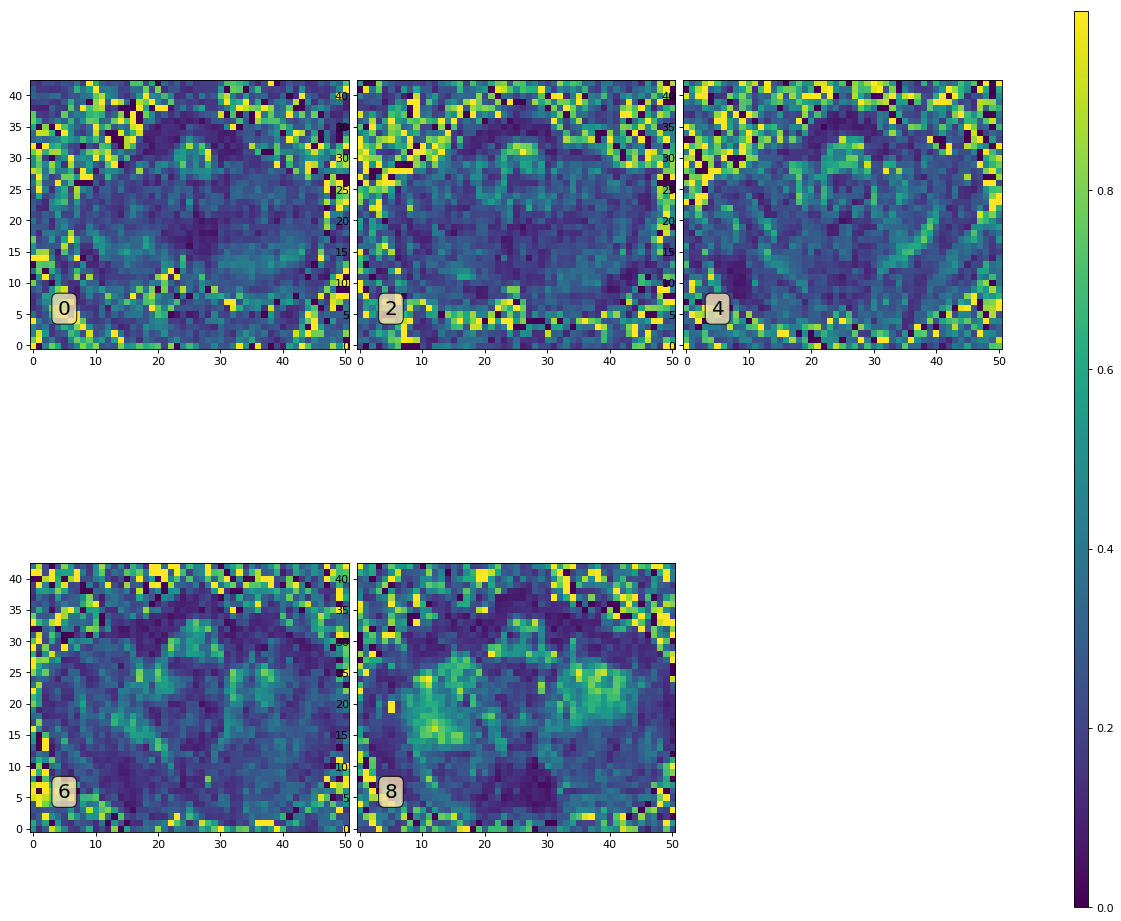

In [17]:
FA = dti.fractional_anisotropy(tenfit.evals)
plot_3d_z_indices(FA, range(0,9, 2), transpose=True, num_rows=2, num_cols=3)

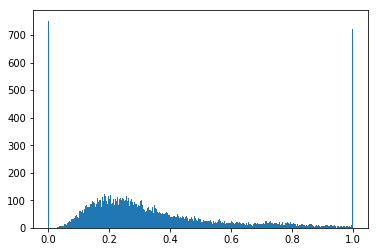

In [18]:
x = plt.hist(FA.ravel(), bins=500)

# Mean Diffusivity

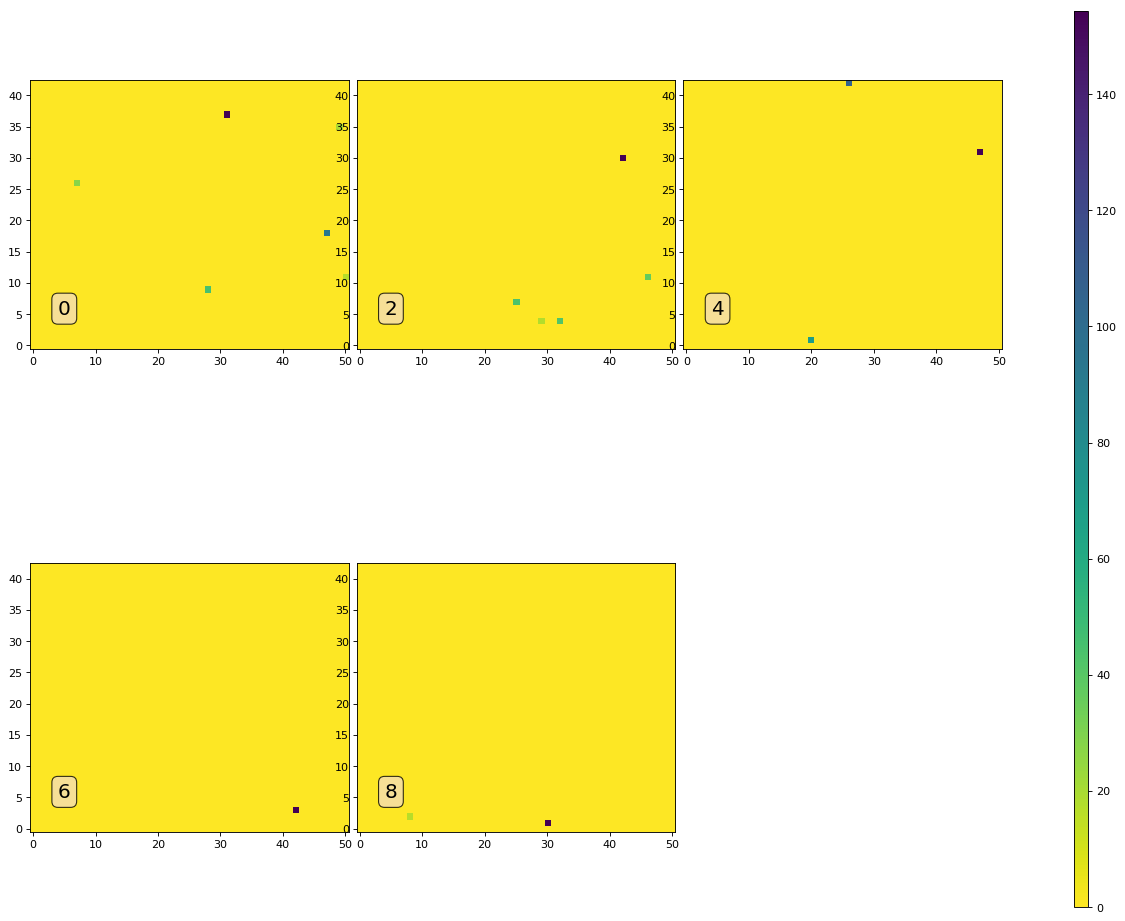

In [19]:
MD1 = dti.mean_diffusivity(tenfit.evals)
plt.set_cmap("viridis_r")
# Plot the MD for a few z-indices
plot_3d_z_indices(MD1, range(0,9, 2), transpose=True, num_rows=2, num_cols=3)

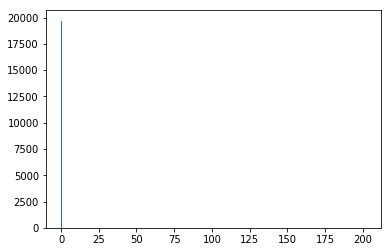

In [20]:
x = plt.hist(MD1.ravel(), bins=500)

# Bi-tensor Model (Free Water)

In [21]:
ADC_water = 3 * 1e-3
b_value = gtab.bvals[1]
Awater_scalar = np.exp(- b_value * ADC_water)
print("Awater_k = %.2f" % Awater_scalar)

Awater_k = 0.05


In [22]:
data_bi = data.astype(np.float_, copy=True)
S0s_bi = data_bi[:,:,:,gtab.b0s_mask]

Make sure there are no zeros in our signal and everything is positive

In [23]:
print("Min = %f, Max=%f" % (data_bi.min(), data_bi.max()))

Min = 0.000000, Max=2123.000000


In [24]:
data_bi[data_bi <= 0] = dti.MIN_POSITIVE_SIGNAL

In [25]:
print("Min = %f, Max=%f" % (data_bi.min(), data_bi.max()))

Min = 0.000100, Max=2123.000000


In [26]:
# Attenuations
Ahat = data_bi.copy() # attenuations
S0s_bi = Ahat[..., 0:1].copy()
Ahat = Ahat / S0s_bi

In [27]:
max_diffusivity = 5e-3
attenuation_min = np.exp(- b_value * max_diffusivity )

min_diffusivity = 0.01 * 1e-3
attenuation_max = np.exp(-b_value * min_diffusivity)

print("Attenuation_min = %.3f, Attenuation_max = %.3f" % 
      (attenuation_min, attenuation_max))

Attenuation_min = 0.007, Attenuation_max = 0.990


In [28]:
#Clip the attenuations to attenuation_min and attenuation_max
mask = Ahat < attenuation_min
mask[:,:,:, gtab.b0s_mask] = False
Ahat[Ahat < attenuation_min] = attenuation_min

mask = Ahat > attenuation_max
mask[:,:,:, gtab.b0s_mask] = False
Ahat[Ahat > attenuation_max] = attenuation_max

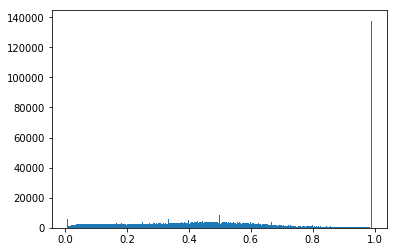

In [29]:
x = plt.hist(Ahat[:,:,:, ~gtab.b0s_mask].ravel(), bins=500)

## Initialization of Free Water Map

Fraction of Data Selected = 0.02


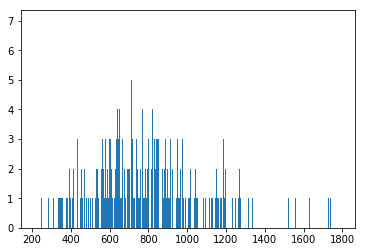

In [30]:
# look at the distribution of voxels in the b0 image that are near 3*1e-3 mm^2/s
mask = np.abs(MD1 - 3 * 1e-3) < 0.2 * 1e-3
print("Fraction of Data Selected = %.2f" % (sum(mask.ravel()) / mask.size))
x = plt.hist(S0s_bi[mask].ravel(), bins=500)

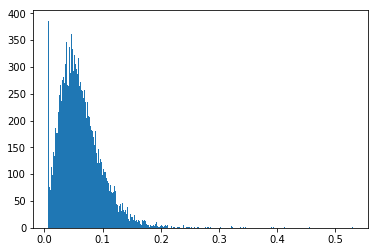

In [31]:
# Lets look at the attentuation when the FA is close to that of water
x = plt.hist(Ahat[:,:,:,1:65][mask].ravel(), bins=500)

In [32]:
#Lets set the value of Swater to be 1500 as that is close 
# to the end of the distribution in percentile terms
Swater = 1500 

Fraction of Data Selected = 0.34


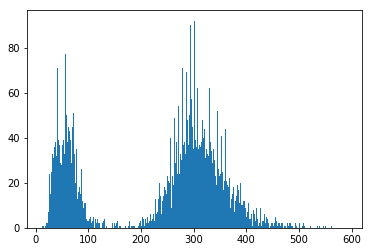

In [33]:
# look at the distribution of voxels that are near 0.8*1e-3 mm^2/s
mask = np.abs(MD1 - 0.8 * 1e-3) < 0.2 * 1e-3
print("Fraction of Data Selected = %.2f" % (sum(mask.ravel()) / mask.size))
x = plt.hist(S0s_bi[mask].ravel(), bins=500)

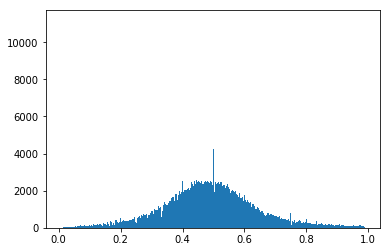

In [34]:
# Lets look at the attentuation when the FA is close to that of 
# white matter 
x = plt.hist(Ahat[:,:,:,1:65][mask].ravel(), bins=500)

In [35]:
# Lets set the value of Stissue to be 200 as that is close
# to the start of the distribution above in percentile terms
Stissue = 200

In [36]:
#Initial free water map

#looking at the distribution of mean diffusivities we can set
lambda_max = 1 * 1e-3 # max diffusivity in tissue
lambda_min = 0.3 * 1e-3 # min diffusivity in tissue

# Max and min attenuation. (Amax uses lambda_min and vice versa)
Amax = np.exp(-b_value * lambda_min)
Amin = np.exp(-b_value * lambda_max)

print("Amin=%.2f, Amax = %.2f" % (Amin, Amax))

Ahat_min = Ahat[..., ~gtab.b0s_mask].min(axis=3)
Ahat_max = Ahat[...,~gtab.b0s_mask].max(axis=3)

print("Ahat_min.shape = %s" % str(Ahat_min.shape))
print("Ahat_max.shape = %s" % str(Ahat_max.shape))

# Note this formula is perhaps a correction of Equation [6]
fmin = (Ahat_min - Awater_scalar) / (Amax - Awater_scalar)
fmax = (Ahat_max - Awater_scalar) / (Amin - Awater_scalar)

print("fmin.shape = %s" % str(fmin.shape))
print("fmax.shape = %s" % str(fmax.shape))

idx = (20, 25, 6)
print("Ahat_min=%.2f, Ahat_max=%.2f, fmax=%.2f, fmin=%.2f" % 
      (Ahat_min[idx], Ahat_max[idx], fmax[idx], fmin[idx]))

# now make sure fmax and fmin are between 0 and 1

print("fmin.max = %.2f, fmin.min=%.2f" % (fmin.max(), fmin.min()))
fmin[fmin <= 0] = 0.01
fmin[fmin >= 1] = 0.99

print("fmax.max = %.2f, fmax.min=%.2f" % (fmax.max(), fmax.min()))
fmax[fmax <= 0] = 0.01
fmax[fmax >= 1] = 0.99
print("fmax.max = %.2f, fmax.min=%.2f" % (fmax.max(), fmax.min()))

print("Ahat_min=%.2f, Ahat_max=%.2f, fmax=%.2f, fmin=%.2f" % 
      (Ahat_min[idx], Ahat_max[idx], fmax[idx], fmin[idx]))

# FIXME: setting fmin to 0 and fmax to 1
fmin[...] = 0 + 0.00001
fmax[...] = 1 - 0.00001

f_init = 1 - (np.log(np.squeeze(S0s_bi) / Stissue) / np.log(Swater / Stissue))
print("f_init.shape = %s" % str(f_init.shape))
mask = f_init < fmin
f_init[mask] = (fmin[mask] + fmax[mask])/2
mask = f_init > fmax
f_init[mask] = (fmin[mask] + fmax[mask])/2

f_init = f_init[:,:,:,np.newaxis]

# This is our starting value of f
print("f_init.shape = %s" % str(f_init.shape))
print("f_init.max = %.2f, f_init.min=%.2f" % (f_init.max(), f_init.min()))

Amin=0.37, Amax = 0.74
Ahat_min.shape = (51, 43, 9)
Ahat_max.shape = (51, 43, 9)
fmin.shape = (51, 43, 9)
fmax.shape = (51, 43, 9)
Ahat_min=0.20, Ahat_max=0.99, fmax=2.96, fmin=0.22
fmin.max = 1.36, fmin.min=-0.06
fmax.max = 2.96, fmax.min=-0.01
fmax.max = 1.00, fmax.min=0.01
Ahat_min=0.20, Ahat_max=0.99, fmax=0.99, fmin=0.22
f_init.shape = (51, 43, 9)
f_init.shape = (51, 43, 9, 1)
f_init.max = 1.00, f_init.min=0.00


In [37]:

print("f_init.max = %.2f" % f_init.max())
print("Ahat.max = %.2f" % Ahat.max())

Cwater = (1 - f_init) * Awater_scalar
print("b_value = %.2f" % b_value)
print("Cwater.max = %.2f" % Cwater.max())
print(Cwater.shape)

Ahat_tissue = (Ahat - Cwater) / f_init
print(Ahat_tissue.shape)

#np.unravel_index(Ahat_tissue.argmax(), Ahat_tissue.shape)
#print(Ahat.max())
#print(Ahat_tissue.max())
#print(Ahat_tissue.argmin())

#idx = np.unravel_index(Ahat_tissue.argmin(), Ahat_tissue.shape)
#print(idx)


f_init.max = 1.00
Ahat.max = 0.99
b_value = 1000.00
Cwater.max = 0.05
(51, 43, 9, 1)
(51, 43, 9, 65)


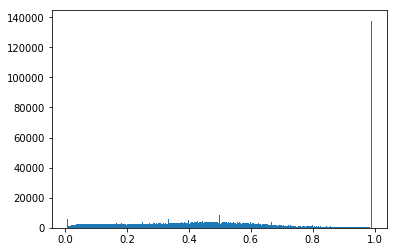

In [38]:
x = plt.hist(Ahat[:,:,:,~gtab.b0s_mask].ravel(), 500)

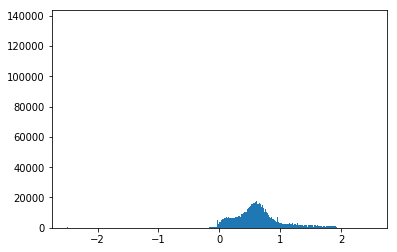

In [39]:
attenuations = Ahat_tissue[:,:,:,~gtab.b0s_mask]
np.clip(attenuations, a_min=-2.5, a_max=2.5, out=attenuations)
x = plt.hist(attenuations.ravel(), 500)

In [40]:
# This is our starting value of D
tenfit.quadratic_form.shape

(51, 43, 9, 3, 3)

In [41]:
tenfit.quadratic_form[20, 20, :, 2, 2]

array([0.00058516, 0.00071938, 0.00063885, 0.00044587, 0.00091081,
       0.00102659, 0.00068477, 0.00016482, 0.00067719])

In [42]:
def create_feature_spatial_manifold(S0, D):
    b0_shape = S0.shape
    d_shape = D.shape
    if (b0_shape[:3] != d_shape[:3]):
        raise ValueError("b0_shape = %s and d_shape = %s." \
                         "The first three dimensions need to match" 
                         % (b0_shape, d_shape))
    manifold_shape = d_shape[:3] + (6,)
    manifold = np.empty(manifold_shape, dtype=D.dtype)
    manifold[...,0] = D[...,0,0]
    manifold[...,1] = D[...,1,1]
    manifold[...,2] = D[...,2,2]
    manifold[...,3] = D[...,0,1] * np.sqrt(2)
    manifold[...,4] = D[...,1,2] * np.sqrt(2)
    manifold[...,5] = D[...,0,2] * np.sqrt(2)
    return(manifold)

manifold = create_feature_spatial_manifold(S0s, tenfit.quadratic_form)

In [43]:
def dx_manifold(manifold, idx):
    "Backwards difference of manifold co-ordinate idx along the x-axis"
    dx = np.empty(manifold.shape[:-1] + (1,), dtype=manifold.dtype)
    dx[1:,:, :, 0] = manifold[1:, :, :, idx] - manifold[:-1,:, :, idx]
    dx[0, :, :, 0] = 0.
    return(dx)

def dy_manifold(manifold, idx):
    "Backwards difference of manifold co-ordinate idx along the y-axis"
    dy = np.empty(manifold.shape[:-1] + (1,), dtype=manifold.dtype)
    dy[:,1:, :, 0] = manifold[:, 1:, :, idx] - manifold[:, :-1, :, idx]
    dy[:, 0, :, 0] = 0.
    return(dy)

def dz_manifold(manifold, idx):
    "Backwards difference of manifold co-ordinate idx along the z-axis"
    dz = np.empty(manifold.shape[:-1] + (1,), dtype=manifold.dtype)
    dz[:, :,1:, 0] = manifold[:,:, 1:, idx] - manifold[:, :, :-1, idx]
    dz[:, :,0, 0] = 0.
    return(dz)

In [44]:
def dpx(p):
    """Backwards derivative of the p,q,r vectors wrt x"""
    p = np.squeeze(p)
    ret = np.empty_like(p)
    ret[:-1, :, :] = p[1:, :, :] - p[:-1, :,:]
    ret[-1, :, :] = 0.
    return(ret)


def dpy(p):
    """Backwards derivative of the p,q,r vectors wrt y"""
    p = np.squeeze(p)
    ret = np.empty_like(p)
    ret[:, :-1, :] = p[:,1:, :] - p[:, :-1, :]
    ret[:, -1, :] = 0.
    return(ret)

def dpz(p):
    """Backwards derivative of the p,q,r vectors wrt z"""
    p = np.squeeze(p)
    ret = np.empty_like(p)
    ret[:,:, :-1] = p[:, :, 1:] - p[:, :, :-1]
    ret[:,:, -1] = 0.
    return(ret)

In [45]:
import logging
logging.debug("Test") # somehow gets jupyter notebook logging to work

GD_LOGGER = logging.getLogger("GD")
#GD_LOGGER.addHandler(logging.FileHandler("GD.log"))

def print_trace(arr, name="array", idx=None, logfunc=GD_LOGGER.debug):
    """Print out information regarding array (optionally at idx)"""
    if idx is None: # print out shape, nan's etc about array
        nanmax = np.nanmax(arr)
        nanmin = np.nanmin(arr)
        nanfrac = np.isnan(arr).sum() / arr.size
        inffrac = np.isinf(arr).sum() / arr.size
        shape = arr.shape
        retstr = "%(name)s: %(shape)s: nanmax=%(nanmax).2f, nanmin=%(nanmin).2f"
        if nanfrac > 0.01 or inffrac > 0.01:
            retstr += ", nanfrac=%(nanfrac).2f, nffrac=%(inffrac).2f"
    else: # print out value at idx
        arr_idx = arr[idx]
        arr_idx_str = str(arr_idx)
        newline = "\n" if len(arr_idx_str) > 50 else ""
        retstr = "%(name)s: " + newline + arr_idx_str
    logfunc(retstr % locals())

GD_LOGGER.setLevel(logging.WARN)
#GD_LOGGER.setLevel(logging.INFO)
#GD_LOGGER.setLevel(logging.DEBUG)

GD_LOGGER.debug("Test message at debug level")
GD_LOGGER.info("Test message at info level")

print_trace(f_init, "f_init")
print_trace(f_init, "f_init", [1, 21, 5, Ellipsis])

In [46]:
beta = 10.
alpha_reg = 1.
alpha_fid = 1.
UNDERFLOW_MIN = 1e-20

In [47]:
num_iterations = 1000
num_gradients = np.sum(~gtab.b0s_mask)
dt = 0.1 / (b_value * num_gradients)
f_curr = f_init.copy()
qk = gtab.bvecs[~gtab.b0s_mask]
manifold = create_feature_spatial_manifold(S0s, tenfit.quadratic_form)

# trace out the value of idx
idx =  (2, 21, 5, Ellipsis)
GD_LOGGER.debug('idx = %s', idx)
print_trace(f_curr, "f_init", idx)
print_trace(fmax, "fmax", idx)
print_trace(fmin, "fmin", idx)

print_trace(manifold * 1000, "manifold * 1000", idx)
print_trace(Ahat, "Ahat", idx)

np.clip(manifold, a_min=0.0, a_max=None, out=manifold)
print_trace(manifold * 1000, "manifold * 1000", idx)

loss_list = []
idx_list = []

for i in range(num_iterations):
    
    GD_LOGGER.info("Starting Iteration: %d" % i)

    X4x = dx_manifold(manifold, 0)
    X4y = dy_manifold(manifold, 0)
    X4z = dz_manifold(manifold, 0)
    
    #print_trace(X4x, "X4x")

    X5x = dx_manifold(manifold, 1)
    X5y = dy_manifold(manifold, 1)
    X5z = dz_manifold(manifold, 1)

    X6x = dx_manifold(manifold, 2)
    X6y = dy_manifold(manifold, 2)
    X6z = dz_manifold(manifold, 2)

    X7x = dx_manifold(manifold, 3)
    X7y = dy_manifold(manifold, 3)
    X7z = dz_manifold(manifold, 3)

    X8x = dx_manifold(manifold, 4)
    X8y = dy_manifold(manifold, 4)
    X8z = dz_manifold(manifold, 4)

    X9x = dx_manifold(manifold, 5)
    X9y = dy_manifold(manifold, 5)
    X9z = dz_manifold(manifold, 5)

    g11 = np.ones(X4x.shape) + beta * (X4x*X4x + X5x*X5x + X6x*X6x + X7x*X7x + 
                                       X8x*X8x + X9x*X9x)
    g22 = np.ones(X4y.shape) + beta * (X4y*X4y + X5y*X5y + X6y*X6y + X7y*X7y + 
                                       X8y*X8y + X9y*X9y)
    g33 = np.ones(X4z.shape) + beta * (X4z*X4z + X5z*X5z + X6z*X6z + X7z*X7z + 
                                       X8z*X8z + X9z*X9z)
    g12 = beta * (X4x*X4y + X5x*X5y + X6x*X6y + X7x*X7y + X8x*X8y + X9x*X9y)
    g23 = beta * (X4y*X4z + X5y*X5z + X6y*X6z + X7y*X7z + X8y*X8z + X9y*X9z)
    g13 = beta * (X4x*X4z + X5x*X5z + X6x*X6z + X7x*X7z + X8x*X8z + X9x*X9z)

    #print_trace(g11, "g11")
    
    C11 = g22*g33 - g23*g23
    C22 = g11*g33 - g13*g13
    C33 = g11*g22 - g12*g12
    C12 = -g12*g33 + g13*g23
    C23 = -g11*g23 + g13*g12
    C13 = g12*g23 - g13*g22

    #print_trace(C11, "C11")
    
    detg = g11*C11 + g12*C12 + g13*C13
    #print_trace(detg, "detg")

    gm05 = 1. / np.sqrt(detg)
    #print_trace(gm05, "gm05")

    #del g11, g22, g33, g12, g23, g13

    p4 = C11*X4x + C12*X4y + C13*X4z
    p5 = C11*X5x + C12*X5y + C13*X5z
    p6 = C11*X6x + C12*X6y + C13*X6z
    p7 = C11*X7x + C12*X7y + C13*X7z
    p8 = C11*X8x + C12*X8y + C13*X8z
    p9 = C11*X9x + C12*X9y + C13*X9z

    q4 = C12*X4x + C22*X4y + C23*X4z
    q5 = C12*X5x + C22*X5y + C23*X5z
    q6 = C12*X6x + C22*X6y + C23*X6z
    q7 = C12*X7x + C22*X7y + C23*X7z
    q8 = C12*X8x + C22*X8y + C23*X8z
    q9 = C12*X9x + C22*X9y + C23*X9z

    r4 = C13*X4x + C23*X4y + C33*X4z
    r5 = C13*X5x + C23*X5y + C33*X5z
    r6 = C13*X6x + C23*X6y + C33*X6z
    r7 = C13*X7x + C23*X7y + C33*X7z
    r8 = C13*X8x + C23*X8y + C33*X8z
    r9 = C13*X9x + C23*X9y + C33*X9z

    #print_trace(p4, "p4")
 
    #del C11, C22, C33, C12, C23, C13

    # Beltrami operator incrementals
    b4inc = (dpx(p4 * gm05) + dpy(q4 * gm05) + dpz(r4 * gm05)) * np.squeeze(gm05)
    b5inc = (dpx(p5 * gm05) + dpy(q5 * gm05) + dpz(r5 * gm05)) * np.squeeze(gm05)
    b6inc = (dpx(p6 * gm05) + dpy(q6 * gm05) + dpz(r6 * gm05)) * np.squeeze(gm05)
    b7inc = (dpx(p7 * gm05) + dpy(q7 * gm05) + dpz(r7 * gm05)) * np.squeeze(gm05)
    b8inc = (dpx(p8 * gm05) + dpy(q8 * gm05) + dpz(r8 * gm05)) * np.squeeze(gm05)
    b9inc = (dpx(p9 * gm05) + dpy(q9 * gm05) + dpz(r9 * gm05)) * np.squeeze(gm05)

    #print_trace(b4inc, "b4inc")
    
    Ahat_tissue_curr = \
        qk[:, 0] * qk[:, 0] * manifold[..., 0:1] + \
        qk[:, 1] * qk[:, 1] * manifold[..., 1:2] + \
        qk[:, 2] * qk[:, 2] * manifold[..., 2:3] + \
        qk[:, 0] * qk[:, 1] * manifold[..., 3:4] * np.sqrt(2) + \
        qk[:, 1] * qk[:, 2] * manifold[..., 4:5] * np.sqrt(2) + \
        qk[:, 0] * qk[:, 2] * manifold[..., 5:6] * np.sqrt(2)
    np.clip(Ahat_tissue_curr, a_min=1e-7, a_max=None, out=Ahat_tissue_curr) # prevent underflow
    Ahat_tissue_curr = np.exp(-b_value * Ahat_tissue_curr)
    print_trace(Ahat_tissue_curr, "Ahat_tissue_curr", idx)
         
    A_bi = Ahat_tissue_curr * f_curr + (1 - f_curr) * Awater_scalar
    print_trace(A_bi, "A_bi", idx)

    fidmat = f_curr * (Ahat[..., ~gtab.b0s_mask] - A_bi) * Ahat_tissue_curr
    print_trace(fidmat, "fidmat", idx)
    
    fid4inc = (fidmat * (qk[:, 0] * qk[:, 0])).sum(axis=-1)
    fid5inc = (fidmat * (qk[:, 1] * qk[:, 1])).sum(axis=-1)
    fid6inc = (fidmat * (qk[:, 2] * qk[:, 2])).sum(axis=-1)
    fid7inc = (fidmat * (qk[:, 0] * qk[:, 1])).sum(axis=-1) * np.sqrt(2) # 2 / sqrt(2)
    fid8inc = (fidmat * (qk[:, 1] * qk[:, 2])).sum(axis=-1) * np.sqrt(2)
    fid9inc = (fidmat * (qk[:, 0] * qk[:, 2])).sum(axis=-1) * np.sqrt(2)
    print_trace(fid4inc, "fid4inc", idx)
    print_trace(fid5inc, "fid5inc", idx)
    print_trace(fid6inc, "fid6inc", idx)
    print_trace(fid7inc, "fid7inc", idx)
    print_trace(fid8inc, "fid8inc", idx)
    print_trace(fid9inc, "fid9inc", idx)
    
    #incrementals are the sum of the fidelity incrementals and the beltrami incrementals
    def increment_manifold_coefs(fidinc, beltinc):
        return(alpha_fid * b_value * fid4inc + alpha_reg * b4inc)
    
    x4inc = increment_manifold_coefs(fid4inc, b4inc)
    x5inc = increment_manifold_coefs(fid5inc, b5inc)
    x6inc = increment_manifold_coefs(fid6inc, b6inc)
    x7inc = increment_manifold_coefs(fid7inc, b7inc)
    x8inc = increment_manifold_coefs(fid8inc, b8inc)
    x9inc = increment_manifold_coefs(fid9inc, b9inc)

    finc = (-b_value) * (
        (Ahat[..., ~gtab.b0s_mask] - A_bi) * (Ahat_tissue_curr - Awater_scalar)).sum(axis=-1)
    print_trace(finc, "finc", idx)
    
    loss_euc = np.linalg.norm(Ahat[..., ~gtab.b0s_mask] - A_bi, axis=-1)
    print_trace(loss_euc, "loss_euc", idx)

    loss_vol = np.sqrt(detg)
    print_trace(loss_vol, "loss_vol", idx)
    
    if idx is not None:
        idx_list.append([loss_euc[idx].copy(), f_curr[idx].squeeze().copy(), finc[idx].copy(), 
                         manifold[...,0][idx].copy(), x4inc[idx].copy() ])
    
    loss_euc = np.sum(loss_euc)
    loss_vol = np.sum(loss_vol)
    loss = alpha_fid * loss_euc + alpha_reg * loss_vol
    
    loss_list.append([loss_euc, loss_vol, loss])
    GD_LOGGER.debug("loss = %.2f, loss_euc=%.2f, loss_vol=%.2f" %(loss, loss_euc, loss_vol))
        
    manifold[...,0] -= dt * x4inc
    manifold[...,1] -= dt * x5inc
    manifold[...,2] -= dt * x6inc
    manifold[...,3] -= dt * x7inc
    manifold[...,4] -= dt * x8inc
    manifold[...,5] -= dt * x9inc

    np.clip(manifold, a_min=UNDERFLOW_MIN, a_max= 1 - UNDERFLOW_MIN, out=manifold)
    print_trace(manifold * 1000, "manifold * 1000", idx)
    
    f_curr[...,0] -= dt * finc
    # make sure that the f values stay constrained
    f_curr = f_curr.squeeze()
    np.clip(f_curr, a_min=fmin, a_max=fmax, out=f_curr)
    f_curr = f_curr[...,np.newaxis]
    print_trace(f_curr, "f_curr", idx)
    #set_trace()
    
loss_array = np.rec.fromrecords(loss_list, names="fidelity,beltrami,loss")
idx_array = np.rec.fromrecords(idx_list, names="loss,f,finc,x4m,x4inc")

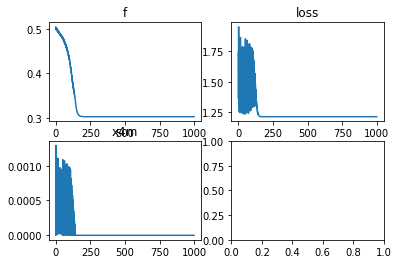

In [48]:
# Plot tissue map, loss functions for idx
fig, axes = plt.subplots(2, 2)
axes[0,0].set_title("f")
axes[0,0].plot(idx_array.f)
axes[0,1].set_title("loss")
axes[0,1].plot(idx_array.loss)
axes[1,0].set_title("x4m")
axes[1,0].plot(idx_array.x4m)

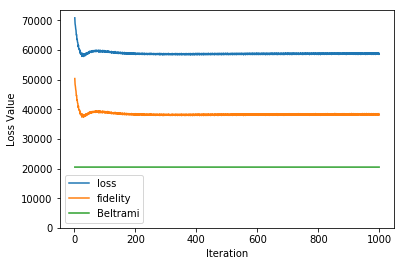

In [49]:
#loss functions
loss_array.loss[0:2] = np.NaN
plt.plot(loss_array.loss, label="loss")
loss_array.fidelity[0:2] = np.NaN
plt.plot(loss_array.fidelity, label="fidelity")
loss_array.beltrami[0:2] = np.NaN
plt.plot(loss_array.beltrami, label="Beltrami")
plt.gca().set_ylim(ymin=0)
plt.xlabel("Iteration")
plt.ylabel("Loss Value")
plt.legend()

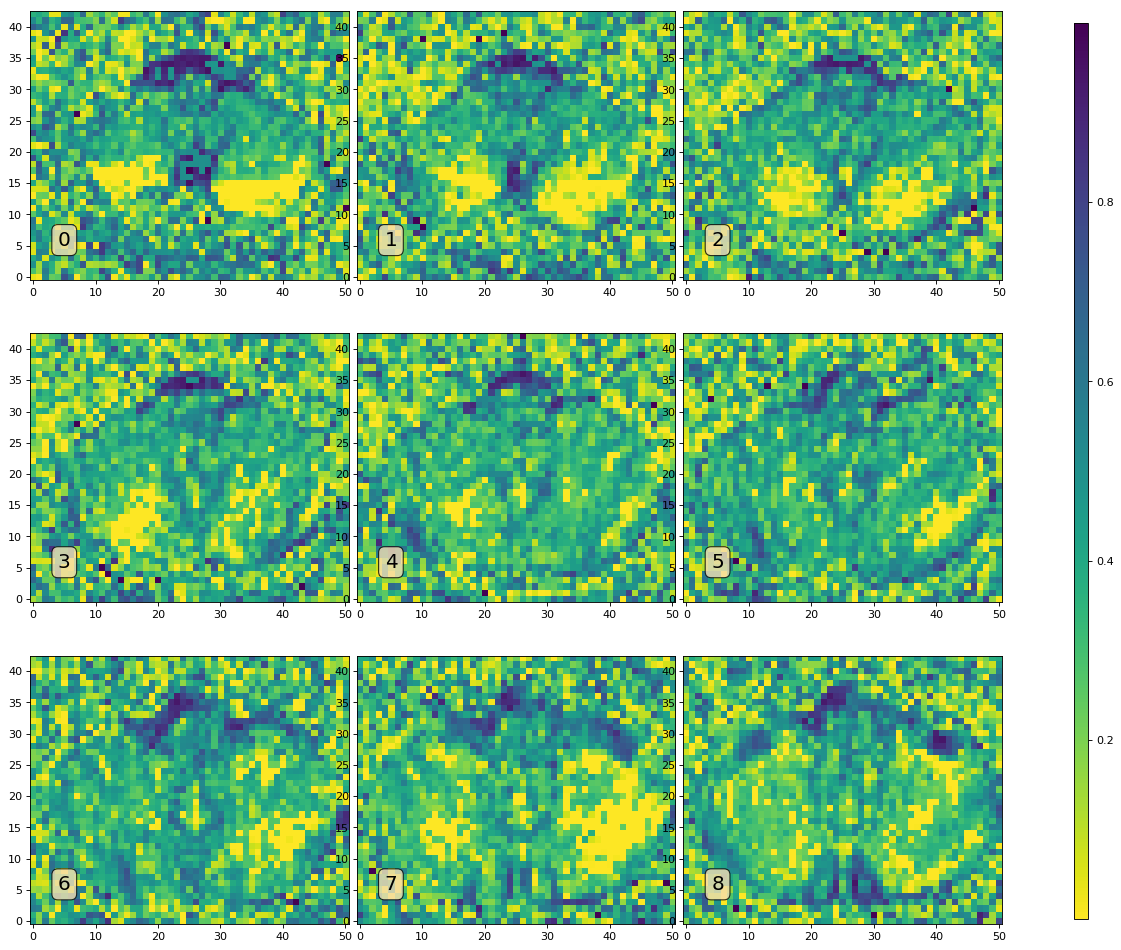

In [50]:
# free water map after iterations
plt.set_cmap("viridis_r")
plot_3d_z_indices(1 - f_curr.squeeze(), range(0,9, 1), transpose=True, num_rows=3, num_cols=3)

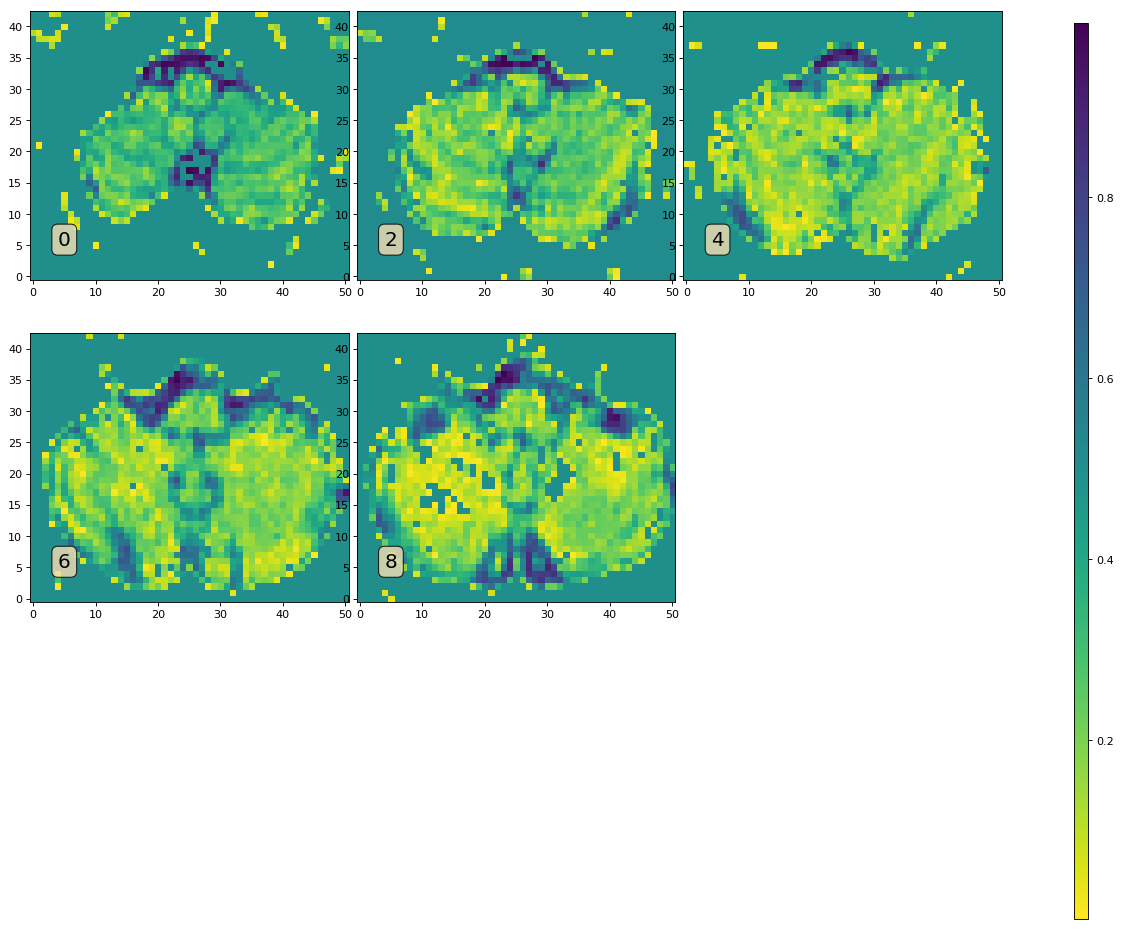

In [51]:
# initial Free water map
plt.set_cmap("viridis_r")
plot_3d_z_indices(1 - f_init.squeeze(), range(0,9, 2), transpose=True, num_rows=3, num_cols=3)

In [52]:
# save free water output to file
fw_file = base_filename + "_fw_map.nii.gz"
nib.save(nib.Nifti1Image((1 - f_curr).squeeze(), img.affine), fw_file)